<a href="https://colab.research.google.com/github/MizDaWiz/Basic-DL-Projects/blob/main/ImgSegmentTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Task 1 : Set up colab gpu runtime environment

In [ ]:
!pip install segmentation-models-pytorch
!pip install -U git+https://github.com/albumentations-team/albumentations
!pip install --upgrade opencv-contrib-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 97 kB 7.4 MB/s 
     |████████████████████████████████| 58 kB 4.8 MB/s 
     |████████████████████████████████| 376 kB 51.7 MB/s 
  Created wheel for efficientnet-pytorch: filename=efficientnet_pytorch-0.7.1-py3-none-any.whl size=16446 sha256=be7b08a05bf5dac3f0beebb706b6bff7063e869ac0790a108e60b6ea38367bc3
  Stored in directory: /root/.cache/pip/wheels/0e/cc/b2/49e74588263573ff778da58cc99b9c6349b496636a7e165be6
  Created wheel for pretrainedmodels: filename=pretrainedmodels-0.7.4-py3-none-any.whl size=60965 sha256=587815bcebe7623de30898b9ab9b20e703c2f0eab8ddd613d65eec017d0bfdf3
  Stored in directory: /root/.cache/pip/wheels/ed/27/e8/9543d42de2740d3544db96aefef63bda3f2c1761b3334f4873
Successfully built efficientnet-pytorch pretrainedmodels
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning htt

# Download Dataset

original author of the dataset :
https://github.com/VikramShenoy97/Human-Segmentation-Dataset


In [ ]:
!git clone https://github.com/parth1620/Human-Segmentation-Dataset-master.git

Cloning into 'Human-Segmentation-Dataset-master'...
remote: Enumerating objects: 592, done.
remote: Counting objects: 100% (592/592), done.
remote: Compressing objects: 100% (591/591), done.
remote: Total 592 (delta 3), reused 587 (delta 1), pack-reused 0
Receiving objects: 100% (592/592), 13.60 MiB | 18.35 MiB/s, done.
Resolving deltas: 100% (3/3), done.


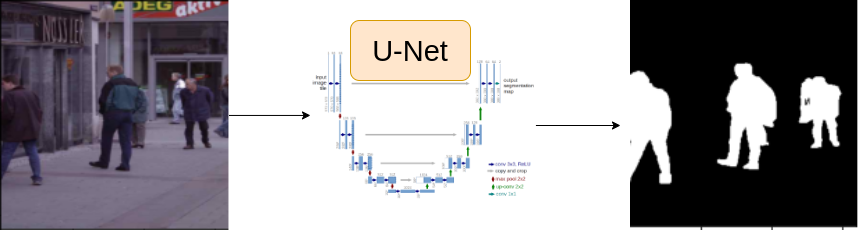

# Some Common Imports

In [ ]:
import sys
sys.path.append('/content/Human-Segmentation-Dataset-master')

In [ ]:
import torch 
import cv2

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt 

from sklearn.model_selection import train_test_split
from tqdm import tqdm

import helper

# Task : 2 Setup Configurations

In [ ]:
CSV_FILE='/content/Human-Segmentation-Dataset-master/train.csv'
DATA_DIR='/content/'

DEVICE ='cuda'

EPOCHS = 25
LR = 0.003
IMG_SIZE = 320
BATCH_SIZE= 16

ENCODER= 'timm-efficientnet-b0'
WEIGHTS= 'imagenet'

In [ ]:
df= pd.read_csv(CSV_FILE)
df.head()

,masks,images
0,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
1,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
2,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
3,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...
4,Human-Segmentation-Dataset-master/Ground_Truth...,Human-Segmentation-Dataset-master/Training_Ima...


In [ ]:
row= df.iloc[0]

image_path=row.images
mask_path=row.masks

image= cv2.imread(image_path)
image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

mask= cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) / 255.0

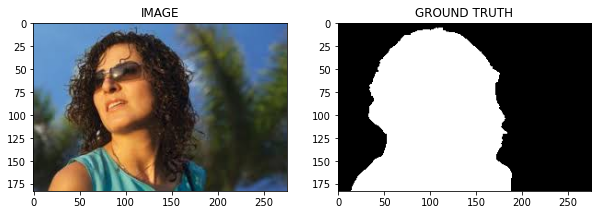

In [ ]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,5))
        
ax1.set_title('IMAGE')
ax1.imshow(image)

ax2.set_title('GROUND TRUTH')
ax2.imshow(mask,cmap = 'gray')

In [ ]:
train_df, valid_df = train_test_split(df, test_size=0.2, random_state=42)

# Task 3 : Augmentation Functions

albumentation documentation : https://albumentations.ai/docs/

In [ ]:
import albumentations as A

In [ ]:
def get_train_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE),
      A.HorizontalFlip(p = 0.5),
      A.VerticalFlip(p = 0.5)
  ])

def get_valid_augs():
  return A.Compose([
      A.Resize(IMG_SIZE, IMG_SIZE)
  ])

# Task 4 : Create Custom Dataset 

In [ ]:
from torch.utils.data import Dataset

In [ ]:
class SegmentationDataset(Dataset):

  def __init__(self, df, augmentations):

    self.df = df
    self.augmentations= augmentations

  def __len__(self):
    return len(self.df)

  def __getitem__(self, idx):

    row = self.df.iloc[idx]

    image_path = row.images
    mask_path = row.masks 

    image = cv2.imread(image_path)
    image=cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    mask = cv2.imread(mask_path, cv2.IMREAD_GRAYSCALE) #(h,w)
    mask = np.expand_dims(mask, axis= -1)              #(h,w,c)

    if self.augmentations:
      data= self.augmentations(image=image, mask=mask)
      image=data['image']
      mask=data['mask']

    #(h,w,c)->(c,h,w)
    image= np.transpose(image, (2,0,1)).astype(np.float32)
    mask= np.transpose(mask, (2,0,1)).astype(np.float32)

    image = torch.Tensor(image)/ 255.0
    mask = torch.round(torch.Tensor(mask)/ 255.0)

    return image, mask


In [ ]:
trainset=SegmentationDataset(train_df, get_train_augs())
validset=SegmentationDataset(valid_df, get_valid_augs())

In [ ]:
print(f"Size of Trainset : {len(trainset)}")
print(f"Size of Validset : {len(validset)}")

Size of Trainset : 232
Size of Validset : 58


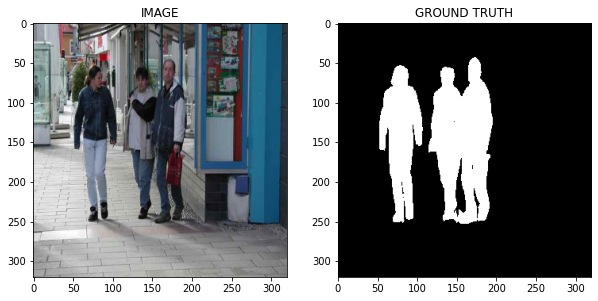

In [ ]:
idx = 42

image, mask = trainset[idx]
helper.show_image(image, mask)


# Task 5 : Load dataset into batches

In [ ]:
from torch.utils.data import DataLoader

In [ ]:
trainloader = DataLoader(trainset, batch_size= BATCH_SIZE, shuffle=True)
validloader = DataLoader(validset, batch_size=BATCH_SIZE)

In [ ]:
print(f"Total no. of batches in trainloader: {len(trainloader)}")
print(f"Total no. of batches in validloader: {len(validloader)}")

Total no. of batches in trainloader: 15
Total no. of batches in validloader: 4


In [ ]:
for image, mask in trainloader: 
  break

print(f"One batch_image shape: {image.shape}")
print(f"One batch_mask shape: {mask.shape}")

One batch_image shape: torch.Size([16, 3, 320, 320])
One batch_mask shape: torch.Size([16, 1, 320, 320])


# Task 6 : Create Segmentation Model

segmentation_models_pytorch documentation : https://smp.readthedocs.io/en/latest/

In [ ]:
from torch import nn
import segmentation_models_pytorch as smp 
from segmentation_models_pytorch.losses import DiceLoss

In [ ]:
#Basic Template to initialize model in PyTorch
class SegmentationModel(nn.Module):

  def __init__(self):
    super(SegmentationModel, self).__init__()
#   
    self.arc = smp.Unet(
        encoder_name=ENCODER,
        encoder_weights = WEIGHTS, 
        in_channels = 3,
        classes = 1,
        activation = None 
    )
  def forward(self, images, masks = None):
    logits = self.arc(images)

    if masks != None:
      loss1 = DiceLoss(mode='binary')(logits, masks)
      loss2 = nn.BCEWithLogitsLoss()(logits, masks)
      return logits, loss1 + loss2 
    return logits


In [ ]:
model  = SegmentationModel()
model.to(DEVICE)

Downloading: "https://github.com/rwightman/pytorch-image-models/releases/download/v0.1-weights/tf_efficientnet_b0_aa-827b6e33.pth" to /root/.cache/torch/hub/checkpoints/tf_efficientnet_b0_aa-827b6e33.pth


  0%|          | 0.00/20.4M [00:00<?, ?B/s]

SegmentationModel(
  (arc): Unet(
    (encoder): EfficientNetEncoder(
      (conv_stem): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (act1): Swish()
      (blocks): Sequential(
        (0): Sequential(
          (0): DepthwiseSeparableConv(
            (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
            (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
            (act1): Swish()
            (se): SqueezeExcite(
              (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
              (act1): Swish()
              (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
              (gate): Sigmoid()
            )
            (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
            (bn2): BatchNorm2d(16, eps

# Task 7 : Create Train and Validation Function 

In [ ]:
def train_fn(data_loader, model, optimizer):

  model.train()
  total_loss= 0.0

  for images, masks in tqdm(data_loader):
    
    images = images.to(DEVICE)
    masks = masks.to(DEVICE)

    optimizer.zero_grad()
    logits, loss = model(images, masks)
    loss.backward() # get grads
    optimizer.step() #update weights

    total_loss +=loss.item()

  return total_loss/len(data_loader)


In [ ]:
def eval_fn(data_loader, model):

  model.eval()
  total_loss= 0.0
  
  with torch.no_grad():
    for images, masks in tqdm(data_loader):
      
      images = images.to(DEVICE)
      masks = masks.to(DEVICE)

      
      logits, loss = model(images, masks)
      
      total_loss +=loss.item()

  return total_loss/len(data_loader)


# Task 8 : Train Model

In [ ]:
optimizer= torch.optim.Adam(model.parameters(), lr = LR)

In [ ]:
best_valid_loss= np.inf

for i in range(EPOCHS):

  train_loss = train_fn(trainloader, model, optimizer)
  valid_loss = eval_fn(validloader, model)

  if valid_loss < best_valid_loss:
    torch.save(model.state_dict(), 'best_model.pt')
    print("SAVED MODEL")
    best_valid_loss= valid_loss
  
  print(f"Epoch: {i+1} Train loss: {train_loss} Valid_loss: {valid_loss}")


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


SAVED MODEL
Epoch: 1 Train loss: 0.818598477045695 Valid_loss: 2.5185534358024597


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


SAVED MODEL
Epoch: 2 Train loss: 0.3960656026999156 Valid_loss: 0.41273483633995056


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


SAVED MODEL
Epoch: 3 Train loss: 0.3191703915596008 Valid_loss: 0.3763306438922882


100%|██████████| 4/4 [00:00<00:00,  4.79it/s]


SAVED MODEL
Epoch: 4 Train loss: 0.26324866513411205 Valid_loss: 0.2630755603313446


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


SAVED MODEL
Epoch: 5 Train loss: 0.24999351799488068 Valid_loss: 0.25323978438973427


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


Epoch: 6 Train loss: 0.22830922702948253 Valid_loss: 0.29407455399632454


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


SAVED MODEL
Epoch: 7 Train loss: 0.20839824775854746 Valid_loss: 0.24990925192832947


100%|██████████| 4/4 [00:00<00:00,  4.86it/s]


SAVED MODEL
Epoch: 8 Train loss: 0.1888537347316742 Valid_loss: 0.24815994128584862


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch: 9 Train loss: 0.17435131669044496 Valid_loss: 0.29963890090584755


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


SAVED MODEL
Epoch: 10 Train loss: 0.2504219442605972 Valid_loss: 0.2066270001232624


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch: 11 Train loss: 0.18511821329593658 Valid_loss: 0.23132286593317986


100%|██████████| 4/4 [00:00<00:00,  4.84it/s]


Epoch: 12 Train loss: 0.1526557887593905 Valid_loss: 0.22586942091584206


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


SAVED MODEL
Epoch: 13 Train loss: 0.19908270041147869 Valid_loss: 0.20571381971240044


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch: 14 Train loss: 0.1535323609908422 Valid_loss: 0.23783785849809647


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch: 15 Train loss: 0.14001622249682744 Valid_loss: 0.21180152148008347


100%|██████████| 4/4 [00:00<00:00,  4.75it/s]


SAVED MODEL
Epoch: 16 Train loss: 0.15497911870479583 Valid_loss: 0.18629641085863113


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


Epoch: 17 Train loss: 0.14850639949242275 Valid_loss: 0.23742792755365372


100%|██████████| 4/4 [00:00<00:00,  4.77it/s]


SAVED MODEL
Epoch: 18 Train loss: 0.12358737041552861 Valid_loss: 0.16704326681792736


100%|██████████| 4/4 [00:00<00:00,  4.74it/s]


Epoch: 19 Train loss: 0.11528481344381968 Valid_loss: 0.2272784411907196


100%|██████████| 4/4 [00:00<00:00,  4.80it/s]


Epoch: 20 Train loss: 0.10076825122038523 Valid_loss: 0.17371012456715107


100%|██████████| 4/4 [00:00<00:00,  4.82it/s]


SAVED MODEL
Epoch: 21 Train loss: 0.0871622567375501 Valid_loss: 0.16235806234180927


100%|██████████| 4/4 [00:00<00:00,  4.78it/s]


SAVED MODEL
Epoch: 22 Train loss: 0.10247387190659842 Valid_loss: 0.14872495457530022


100%|██████████| 4/4 [00:00<00:00,  4.81it/s]


Epoch: 23 Train loss: 0.12422076314687729 Valid_loss: 0.1974094845354557


100%|██████████| 4/4 [00:00<00:00,  4.76it/s]


Epoch: 24 Train loss: 0.10789822563529014 Valid_loss: 0.2022838145494461


100%|██████████| 4/4 [00:00<00:00,  4.70it/s]

Epoch: 25 Train loss: 0.09565388411283493 Valid_loss: 0.20690909959375858


# Task 9 : Inference

In [ ]:
idx = 37

model.load_state_dict(torch.load('/content/best_model.pt'))

image, mask = validset[idx]

logits_mask = model(image.to(DEVICE).unsqueeze(0)) #(C,H,W) -> (1, C, H, W)
pred_mask = torch.sigmoid(logits_mask)
pred_mask = (pred_mask > 0.5)*1.0


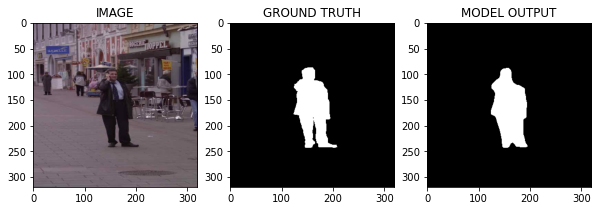

In [ ]:
helper.show_image(image, mask, pred_mask.detach().cpu().squeeze(0))